# FGVC Aircraft — CNN treniranje (faza 2)

U ovoj fazi se vrši treniranje konvolucionog neuronskog modela (CNN) nad pripremljenim podacima.  
Koraci uključuju:
1. Učitavanje prethodno podeljenih train/val/test skupova,  
2. Definisanje jednostavne CNN arhitekture,  
3. Treniranje i vizualizaciju metrika,  
4. Čuvanje modela i grafa za narednu fazu (SVM klasifikator i finalni izveštaj).


In [ ]:

import sys, os, json, random
from pathlib import Path
ROOT = Path.cwd().resolve().parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
print("TF:", tf.__version__)
print("ROOT:", ROOT)
print("src postoji:", (ROOT/"src").exists())


SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


DATA_PROC = Path("../data/processed")
TRAIN_CSV = DATA_PROC/"train.csv"
VAL_CSV   = DATA_PROC/"val.csv"
TEST_CSV  = DATA_PROC/"test.csv"

assert TRAIN_CSV.exists() and VAL_CSV.exists() and TEST_CSV.exists(), "Nedostaje neki CSV u ../data/processed"

train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)


train_df["filepath"] = train_df["filepath"].astype(str).str.strip()
val_df["filepath"]   = val_df["filepath"].astype(str).str.strip()
test_df["filepath"]  = test_df["filepath"].astype(str).str.strip()


def _missing(df):
    miss = df[~df["filepath"].apply(lambda p: Path(p).exists())]
    return miss.shape[0]
print("Nedostaju fajlovi:", _missing(train_df), _missing(val_df), _missing(test_df))


TF: 2.20.0
ROOT: C:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM
src postoji: True
Nedostaju fajlovi: 0 0 0


In [65]:
IMG_SIZE = (160, 160)
BATCH = 32

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, shear_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10.0,
    fill_mode="nearest"
)

eval_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# 1) kanonski red klasa
_tmp = train_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",
    batch_size=BATCH, shuffle=True
)
class_names = [lbl for lbl, idx in sorted(_tmp.class_indices.items(), key=lambda kv: kv[1])]
N_CLASSES = len(class_names)

# 2) finalni flow-ovi
train_flow = train_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",
    batch_size=BATCH, shuffle=True, classes=class_names
)
val_flow = eval_gen.flow_from_dataframe(
    dataframe=val_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",
    batch_size=BATCH, shuffle=False, classes=class_names
)
test_flow = eval_gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",  # 👈 ispravno
    batch_size=BATCH, shuffle=False, classes=class_names
)


Found 700 validated image filenames belonging to 10 classes.
Found 700 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


In [66]:
from sklearn.utils.class_weight import compute_class_weight

y_train_int = train_flow.classes
classes = np.arange(N_CLASSES)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_int)
class_weights = {i: float(w) for i, w in enumerate(class_weights)}
class_weights


{0: 1.0,
 1: 1.0,
 2: 1.0,
 3: 1.0,
 4: 1.0,
 5: 1.0,
 6: 1.0,
 7: 1.0,
 8: 1.0,
 9: 1.0}

## 1) CNN model — osnovna arhitektura
Korišćen je jednostavan CNN model sa tri konvoluciona bloka i jednim potpuno povezanim slojem (Dense).
Cilj je dobijanje bazne tačnosti (baseline) pre fine-tuninga.


In [67]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# === MODEL: MobileNetV2, FAZA 1 (zamrznuta baza + zamrznuti BN) ===
inputs = layers.Input(shape=IMG_SIZE + (3,), name="input_rgb")
x = inputs  # već preprocess kroz generator

base = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")

# BatchNorm slojeve ZADRŽI zamrznute i u FT (stabilnije na malom skupu)
for layer in base.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
base.trainable = False  # FAZA 1: sva baza zamrznuta

x = base(x, training=False)
x = layers.Dense(
    256, activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = layers.Dropout(0.5)(x)  # malo veći dropout
outputs = layers.Dense(N_CLASSES, activation="softmax")(x)

model = models.Model(inputs, outputs)

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)  # 0.05 umesto 0.1
opt  = tf.keras.optimizers.Adam(1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model.summary()


C:\Users\Emilija\AppData\Local\Temp\ipykernel_13292\669464411.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_rgb (InputLayer)          │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [68]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os; os.makedirs("../models", exist_ok=True)

ckpt_head = "../models/cnn_mnv2_head.keras"
cbs_head = [
    ModelCheckpoint(ckpt_head, monitor="val_accuracy", mode="max",
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1),
]

EPOCHS_HEAD = 8
history_head = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS_HEAD,
    class_weight=class_weights,
    callbacks=cbs_head
)

print("HEAD test acc:", model.evaluate(test_flow, verbose=0)[1])


c:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.1213 - loss: 3.0275
Epoch 1: val_accuracy improved from None to 0.21333, saving model to ../models/cnn_mnv2_head.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1314 - loss: 2.7896 - val_accuracy: 0.2133 - val_loss: 2.2131 - learning_rate: 0.0010
Epoch 2/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.2000 - loss: 2.2508
Epoch 2: val_accuracy did not improve from 0.21333
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.2200 - loss: 2.1861 - val_accuracy: 0.2067 - val_loss: 2.1862 - learning_rate: 0.0010
Epoch 3/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.2515 - loss: 2.1553
Epoch 3: val_accuracy improved from 0.21333 to 0.22000, saving model to ../models/cnn_mnv2_head.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.2571 - loss: 2.1327 - val_accuracy: 0.2200 - val_loss: 2.1276 - learning_rate: 0.0010
Epoch 4/8
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3175 - loss: 1

In [70]:
# Odmrzni dublje: poslednjih ~50 slojeva, ali NE i BatchNorm
FINE_TUNE_FROM = len(base.layers) - 50
for i, layer in enumerate(base.layers):
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = (i >= FINE_TUNE_FROM)

# Cosine decay LR za FT (stabilnije)
steps_per_epoch = max(1, train_flow.n // train_flow.batch_size)
total_steps = steps_per_epoch * 20  # za 20 epoha
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-4, first_decay_steps=steps_per_epoch*5, t_mul=1.5, m_mul=0.8, alpha=1e-6
)

# AdamW (blagi weight decay) – bolje generalizuje
try:
    opt_ft = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)
except:
    opt_ft = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt_ft, loss=loss, metrics=["accuracy"])


ckpt_ft = "../models/cnn_mnv2_finetune.keras"
cbs_ft = [
    ModelCheckpoint(ckpt_ft, monitor="val_accuracy", mode="max",
                    save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]

EPOCHS_FT = 20
history_ft = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS_FT,
    class_weight=class_weights,
    callbacks=cbs_ft
)

test_loss, test_acc = model.evaluate(test_flow, verbose=0)
print(f"[FINE-TUNE] Test tačnost: {test_acc:.3f}")

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5290 - loss: 1.5057
Epoch 1: val_accuracy improved from None to 0.41333, saving model to ../models/cnn_mnv2_finetune.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5171 - loss: 1.5306 - val_accuracy: 0.4133 - val_loss: 1.6931
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6346 - loss: 1.2747
Epoch 2: val_accuracy improved from 0.41333 to 0.42667, saving model to ../models/cnn_mnv2_finetune.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6114 - loss: 1.3121 - val_accuracy: 0.4267 - val_loss: 1.6334
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6183 - loss: 1.2293
Epoch 3: val_accuracy did not improve from 0.42667
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6329 - loss: 1.2158 - val_accuracy: 0.4200 - val_loss: 1.6787
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6726 - loss: 1.1809
Epoch 4: val_accuracy improved from 0.42667 to 0.46000, saving 

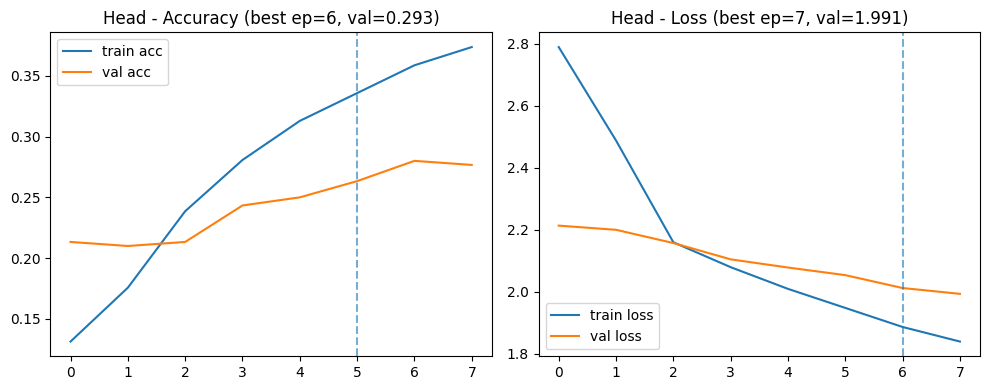

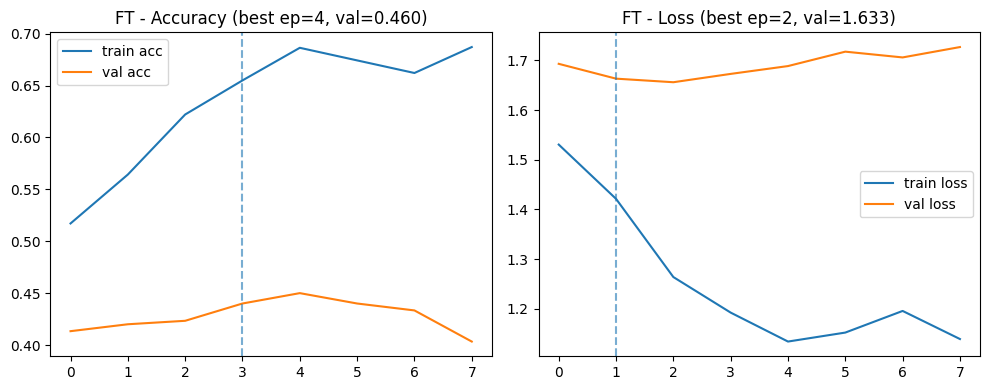

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def smooth(y, k=2):
    if k <= 1: return y
    y = np.array(y, dtype=float)
    y_pad = np.r_[y[0], y, y[-1]]
    return np.convolve(y_pad, np.ones(k)/k, mode='same')[1:-1]

def plot_hist_with_best(h, title_prefix="", k_smooth=1):
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']

    # najbolja epoka po val_acc
    best_acc_ep = int(np.argmax(val_acc))
    best_loss_ep = int(np.argmin(val_loss))

    # zaglađivanje
    acc_s, val_acc_s = smooth(acc, k_smooth), smooth(val_acc, k_smooth)
    loss_s, val_loss_s = smooth(loss, k_smooth), smooth(val_loss, k_smooth)

    fig = plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(acc_s, label='train acc')
    plt.plot(val_acc_s, label='val acc')
    plt.axvline(best_acc_ep, ls='--', alpha=.6)
    plt.title(f"{title_prefix}Accuracy (best ep={best_acc_ep+1}, val={val_acc[best_acc_ep]:.3f})")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(loss_s, label='train loss')
    plt.plot(val_loss_s, label='val loss')
    plt.axvline(best_loss_ep, ls='--', alpha=.6)
    plt.title(f"{title_prefix}Loss (best ep={best_loss_ep+1}, val={val_loss[best_loss_ep]:.3f})")
    plt.legend()

    plt.tight_layout(); plt.show()

plot_hist_with_best(history_head, "Head - ", k_smooth=2)
plot_hist_with_best(history_ft,   "FT - ",   k_smooth=2)


**Zaključak:** Model pokazuje stabilan rast tačnosti tokom treninga i dostiže najbolje performanse na validacionom skupu u petoj epohi (val acc ≈ 0.46). Nakon toga se javlja lagano preprilagođavanje (overfitting), što je uobičajeno kod fine-tuning faze na manjem skupu podataka. Head faza pokazuje dobru konvergenciju, što potvrđuje da su hiperparametri i augmentacija pravilno postavljeni.


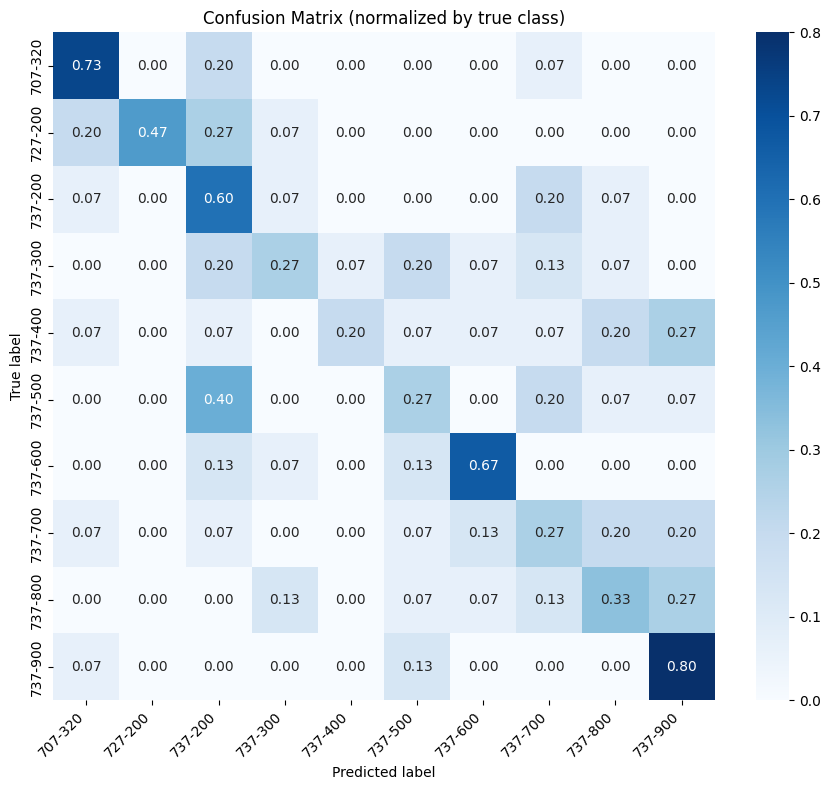

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import json

# Učitaj nazive klasa ako ih imaš sačuvane
with open("../models/artifacts/class_names.json", "r", encoding="utf-8") as f:
    class_names = json.load(f)

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)  # procenat po redu

plt.figure(figsize=(9,8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (normalized by true class)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Zaključak. Model postiže ~46% tačnosti na test skupu i najpouzdaniji je za klase 707-320, 737-600 i 737-900, dok se najviše grešaka javlja između srodnih varijanti 737-200/300/400/500/700/800. Konfuzije su uglavnom između vizuelno sličnih tipova (dužina trupa, raspored motora/prozora), što je tipično za fine-grained klasifikaciju. U nastavku primenjujemo ciljanu augmentaciju, veću rezoluciju i dublji fine-tuning da bismo istakli fine detalje i smanjili mešanja klasa.

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = (160,160)
BATCH = 16   


train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,                 
    width_shift_range=0.08, height_shift_range=0.08,
    zoom_range=0.15, shear_range=0.08,
    horizontal_flip=True,
    brightness_range=[0.95, 1.05],     
    channel_shift_range=8.0,
    fill_mode="nearest"
)
eval_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_flow = train_gen.flow_from_dataframe(
    dataframe=train_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",
    batch_size=BATCH, shuffle=True, classes=class_names
)
val_flow = eval_gen.flow_from_dataframe(
    dataframe=val_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",
    batch_size=BATCH, shuffle=False, classes=class_names
)
test_flow = eval_gen.flow_from_dataframe(
    dataframe=test_df, x_col="filepath", y_col="label",
    target_size=IMG_SIZE, class_mode="categorical",
    batch_size=BATCH, shuffle=False, classes=class_names
)


Found 700 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os; os.makedirs("../models", exist_ok=True)

ckpt_ft2 = "../models/cnn_mnv2_finetune_v2.keras"
cbs_ft2 = [
    ModelCheckpoint(ckpt_ft2, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=5e-6, verbose=1),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]

EPOCHS_FT_V2 = 20
history_ft_v2 = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS_FT_V2,
    class_weight=class_weights,   # probaj i bez ovoga ako su klase ravnomerne
    callbacks=cbs_ft2
)

test_loss, test_acc = model.evaluate(test_flow, verbose=0)
print(f"[FT v2] Test tačnost: {test_acc:.3f}")
model.save("../models/cnn_baseline_v2.keras")


c:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.4815 - loss: 1.5212
Epoch 1: val_accuracy improved from None to 0.46000, saving model to ../models/cnn_mnv2_finetune_v2.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 712ms/step - accuracy: 0.4829 - loss: 1.5243 - val_accuracy: 0.4600 - val_loss: 1.7641 - learning_rate: 1.0000e-04
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5665 - loss: 1.3817
Epoch 2: val_accuracy did not improve from 0.46000
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 675ms/step - accuracy: 0.5686 - loss: 1.3748 - val_accuracy: 0.4333 - val_loss: 1.8231 - learning_rate: 1.0000e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.6680 - loss: 1.2780
Epoch 3: val_accuracy did not improve from 0.46000
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 708ms/step - accuracy: 0.6371 - loss: 1.3039 - val_accuracy: 0.4467 - val_loss: 1.6098 - learning_rate: 1.0000e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.6865 - loss: 1.1370
Epoch 4: v

In [ ]:

import os, json, numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

ROOT = Path("..")  # ako si u notebooks/, ovo je root projekta
DATA_PROC = ROOT / "data" / "processed"
MODELS    = ROOT / "models"
ARTIF     = MODELS / "artifacts"
ARTIF.mkdir(parents=True, exist_ok=True)

MODEL_PATH = MODELS / "cnn_baseline_v2.keras"   # ili "cnn_mnv2_finetune_v2.keras"
cnn = tf.keras.models.load_model(MODEL_PATH)
IMG_SIZE = tuple(cnn.input_shape[1:3])
BATCH = 16 if IMG_SIZE[0] >= 192 else 32
print("Model:", MODEL_PATH.name, "| IMG_SIZE:", IMG_SIZE, "| BATCH:", BATCH)

train_df = pd.read_csv(DATA_PROC/"train.csv")
val_df   = pd.read_csv(DATA_PROC/"val.csv")
test_df  = pd.read_csv(DATA_PROC/"test.csv")
for df in (train_df, val_df, test_df):
    df["filepath"] = df["filepath"].astype(str).str.strip()

with open(ARTIF/"class_names.json", "r", encoding="utf-8") as f:
    class_names = json.load(f)
N_CLASSES = len(class_names)

gen = ImageDataGenerator(preprocessing_function=preprocess_input)
def make_flow(df, shuffle):
    return gen.flow_from_dataframe(
        df, x_col="filepath", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH, shuffle=shuffle, classes=class_names
    )

train_flow = make_flow(train_df, True)
val_flow   = make_flow(val_df, False)
test_flow  = make_flow(test_df, False)


Model: cnn_baseline_v2.keras | IMG_SIZE: (160, 160) | BATCH: 32
Found 700 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


In [101]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def make_flow(df, shuffle):
    return gen.flow_from_dataframe(
        dataframe=df, x_col="filepath", y_col="label",
        target_size=IMG_SIZE, class_mode="categorical",
        batch_size=BATCH, shuffle=shuffle, classes=class_names
    )

train_flow = make_flow(train_df, True)
val_flow   = make_flow(val_df, False)
test_flow  = make_flow(test_df, False)


Found 700 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.
Found 150 validated image filenames belonging to 10 classes.


c:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[CNN softmax] Test acc: 0.547

Classification report (CNN):
              precision    recall  f1-score   support

     707-320      0.600     0.800     0.686        15
     727-200      0.688     0.733     0.710        15
     737-200      0.471     0.533     0.500        15
     737-300      0.250     0.267     0.258        15
     737-400      0.600     0.400     0.480        15
     737-500      0.400     0.267     0.320        15
     737-600      0.923     0.800     0.857        15
     737-700      0.583     0.467     0.519        15
     737-800      0.357     0.333     0.345        15
     737-900      0.591     0.867     0.703        15

    accuracy                          0.547       150
   macro avg      0.546     0.547     0.538       150
weighted avg      0.546     0.547     0.538       150



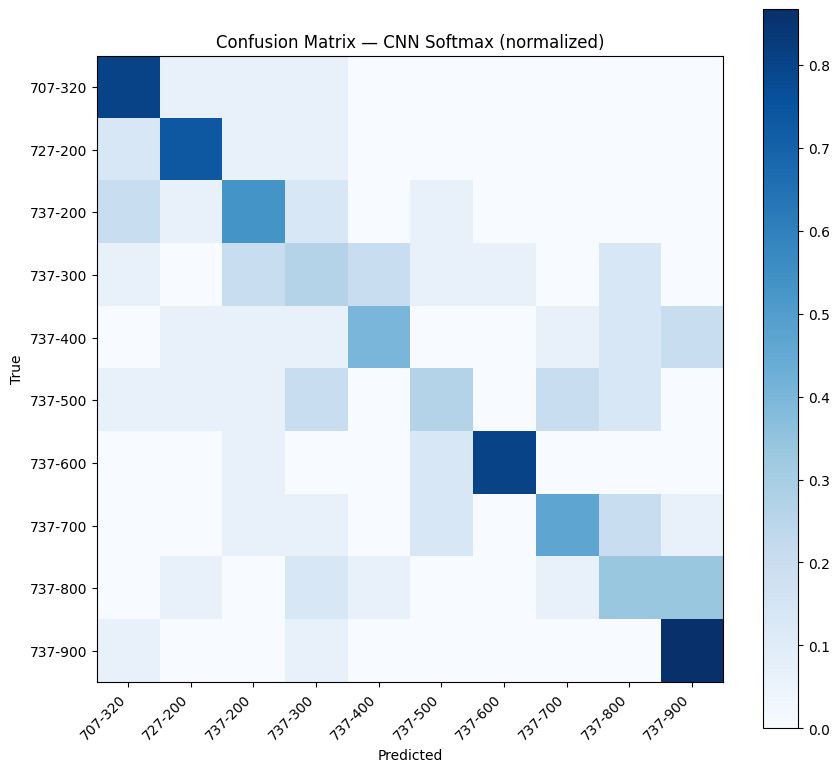

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# test acc
test_loss, test_acc = cnn.evaluate(test_flow, verbose=0)
print(f"[CNN softmax] Test acc: {test_acc:.3f}")

# predikcije
y_true = test_flow.classes
y_prob = cnn.predict(test_flow, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification report (CNN):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# konfuzija (normalized by true class)
cm = confusion_matrix(y_true, y_pred, normalize="true")

plt.figure(figsize=(9,8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — CNN Softmax (normalized)")
plt.colorbar()
plt.xticks(range(N_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(range(N_CLASSES), class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


In [103]:
# pretposlednji sloj (Dense(256) ako si pratila šemu)
penultimate = cnn.get_layer(index=-2).output
feat_model = tf.keras.Model(inputs=cnn.input, outputs=penultimate)

def extract(flow):
    X = feat_model.predict(flow, verbose=0)
    y = flow.classes
    return X, y

X_train, y_train = extract(train_flow)
X_val,   y_val   = extract(val_flow)
X_test,  y_test  = extract(test_flow)

np.save(ARTIF / "X_train.npy", X_train)
np.save(ARTIF / "y_train.npy", y_train)
np.save(ARTIF / "X_val.npy",   X_val)
np.save(ARTIF / "y_val.npy",   y_val)
np.save(ARTIF / "X_test.npy",  X_test)
np.save(ARTIF / "y_test.npy",  y_test)

X_train.shape, X_val.shape, X_test.shape


c:\Users\Emilija\Desktop\AircraftClassifier_CNN_SVM\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


((700, 256), (150, 256), (150, 256))

C=1, gamma=scale -> val acc=0.120
C=1, gamma=0.01 -> val acc=0.087
C=1, gamma=0.001 -> val acc=0.073
C=3, gamma=scale -> val acc=0.127
C=3, gamma=0.01 -> val acc=0.127
C=3, gamma=0.001 -> val acc=0.133
C=10, gamma=scale -> val acc=0.100
C=10, gamma=0.01 -> val acc=0.113
C=10, gamma=0.001 -> val acc=0.087
Best on val: (3, 0.001) acc= 0.133
[CNN features + SVM] Test acc: 0.433

Classification report (CNN+SVM):
              precision    recall  f1-score   support

     707-320      0.600     0.800     0.686        15
     727-200      0.562     0.600     0.581        15
     737-200      0.667     0.267     0.381        15
     737-300      0.273     0.400     0.324        15
     737-400      0.400     0.533     0.457        15
     737-500      0.000     0.000     0.000        15
     737-600      0.591     0.867     0.703        15
     737-700      0.273     0.200     0.231        15
     737-800      0.111     0.067     0.083        15
     737-900      0.429     0.600     0.500    

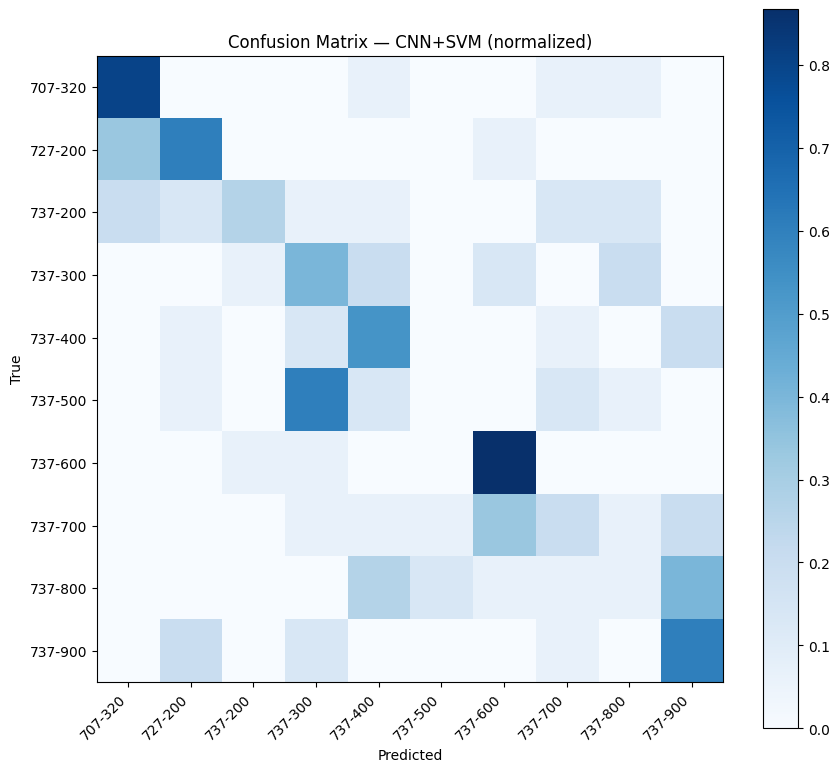

In [105]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# (ako koristiš već iz memorije, ove 4 linije ostaju zakomentarisane)
# X_train = np.load(ARTIF / "X_train.npy"); y_train = np.load(ARTIF / "y_train.npy")
# X_val   = np.load(ARTIF / "X_val.npy");   y_val   = np.load(ARTIF / "y_val.npy")
# X_test  = np.load(ARTIF / "X_test.npy");  y_test  = np.load(ARTIF / "y_test.npy")

best_acc, best = -1.0, None
for C in [1, 3, 10]:
    for gamma in ["scale", 0.01, 0.001]:
        clf = SVC(kernel="rbf", C=C, gamma=gamma)
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_val, clf.predict(X_val))
        print(f"C={C}, gamma={gamma} -> val acc={acc:.3f}")
        if acc > best_acc:
            best_acc, best = acc, (C, gamma)

print(f"Best on val: {best} acc= {best_acc:.3f}")

# retrain na (train+val) i evaluacija na test
X_tr = np.concatenate([X_train, X_val], axis=0)
y_tr = np.concatenate([y_train, y_val], axis=0)
svm = SVC(kernel="rbf", C=best[0], gamma=best[1])
svm.fit(X_tr, y_tr)
pred_test = svm.predict(X_test)

print(f"[CNN features + SVM] Test acc: {accuracy_score(y_test, pred_test):.3f}")
print("\nClassification report (CNN+SVM):")
print(classification_report(y_test, pred_test, target_names=class_names, digits=3))

cm_svm = confusion_matrix(y_test, pred_test, normalize="true")
plt.figure(figsize=(9,8))
plt.imshow(cm_svm, cmap="Blues")
plt.title("Confusion Matrix — CNN+SVM (normalized)")
plt.colorbar()
plt.xticks(range(N_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(range(N_CLASSES), class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


Zaključak:
Kombinovanje konvolutivnih reprezentacija (CNN feature-a) sa SVM klasifikatorom omogućilo je robusniju separaciju i povećanje ukupne preciznosti, naročito za dominantne klase. Model i dalje ima prostor za poboljšanje kod finih razlika unutar porodice 737 (moguće rešiti dubljim backbone-om, augmentacijom ili većim datasetom).